# New Scaling

***

In [26]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import gsw
from datetime import datetime, timedelta
from dateutil.parser import parse
from tqdm import tqdm_notebook as tqdm
from warnings import simplefilter
from dynmodes import dynmodes

%matplotlib inline
simplefilter('ignore')

***

## Local Functions and Definitions

In [3]:
def calc_deformation_radius(rho, z_h, xy, e1t=440, angle=np.pi/2, tol=10):
    """Calculate the baroclinic Rossby deformation radius
    """

    scalefac = np.sin(angle) * e1t
    g_prime = const['g'] * (const['rho_0'] - rho) / const['rho_0']
    R = np.sqrt(g_prime * z_h * (const['H'] - z_h) / const['H']) / const['f']
    H, H_old = const['H'], 0
    while abs(H - H_old) > tol:
        H_old = H
        H = bathy.Bathymetry[xy[1], xy[0]:]
        H = float(H[~np.isnan(H)][:int(R / scalefac)].mean())
        R = np.sqrt(g_prime * z_h * (H - z_h) / H) / const['f']

    return R

In [12]:
def calc_rho(data, depth, loc, tmask, time=False):
    """Calculate the density, rho
    """
    
    if time: mskslc = slice(1, None)
    else: mskslc = slice(None)
    condition = np.broadcast_to(tmask[loc[mskslc]], data[tracers[0]][loc].shape) == 0
    rho = gsw.rho(*[np.ma.masked_where(condition, data[k][loc]) for k in tracers], depth)
    
    return rho

In [25]:
def make_prefix(date, paths, res='h'):
    """Construct path prefix for local SalishSeaCast results given date object and paths dict
    e.g., /results/SalishSea/hindcast.201812/ddmmmyy/SalishSea_1h_yyyymmdd_yyyymmdd
    """

    path = paths['NEMO']
    if 'date_cutoff' in paths and date >= parse(paths['date_cutoff']):
        path = paths['NEMO_cutoff']
    datestr = [date.strftime('%d%b%y').lower(), '_'.join(np.repeat(date.strftime('%Y%m%d'), 2))]
    prefix = os.path.join(path, datestr[0], f'SalishSea_1{res}_{datestr[1]}')
    
    return prefix

In [31]:
# Definitions
HRDPS = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')
bathy = xr.open_dataset('/data/bmoorema/MEOPAR/grid/bathymetry_201702.nc')
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')
const = {'g': 9.81, 'f': 1.11e-4, 'rho_0': 1024, 'H': 200, 'R': 5e3, 'z_h': 10}
depth2d = np.expand_dims(mask.gdept_1d[0, :], axis=1)
tracers = ['vosaline', 'votemper']
subdomain = [114, 398, 334, 898]
sections = [
    {'y': 450, 'x': (235, 315), 'yw': 140, 'xw': (140, 154), 'a': np.arctan(10), 'c': 'r'},
    {'y': 500, 'x': (205, 295), 'yw': 147, 'xw': (130, 149), 'a': np.arctan( 1), 'c': 'darkorange'},
    {'y': 540, 'x': (175, 255), 'yw': 154, 'xw': (121, 140), 'a': np.arctan( 1), 'c': 'gold'},
    {'y': 590, 'x': (130, 205), 'yw': 160, 'xw': (113, 122), 'a': np.arctan( 2), 'c': 'darkslategray'},
    {'y': 640, 'x': (130, 180), 'yw': 170, 'xw': (108, 118), 'a': np.arctan(10), 'c': 'c'},
    {'y': 680, 'x': (130, 200), 'yw': 178, 'xw': (107, 116), 'a': np.arctan( 5), 'c': 'cyan'},
]

In [6]:
# Define path and filename string
path = '/data/bmoorema/results/Lake/S4d'
fn = 'SalishSeaIdeal_1h_20170701_20170706_grid_T.nc'
tmask = mask.tmask[0, :, slice(*subdomain[2:]), slice(*subdomain[:2])]

# Define scaling parameters
param = {
    'u_wind': [5, 10, 15],
    'tau': [0.034, 0.123, 0.280],
    'z_h': [10, 15, 20],
    'rho_surf': [1016, 1018, 1020],
}

# Initialize storage lists
R = [0, 0, 0, 0, 0, 0]

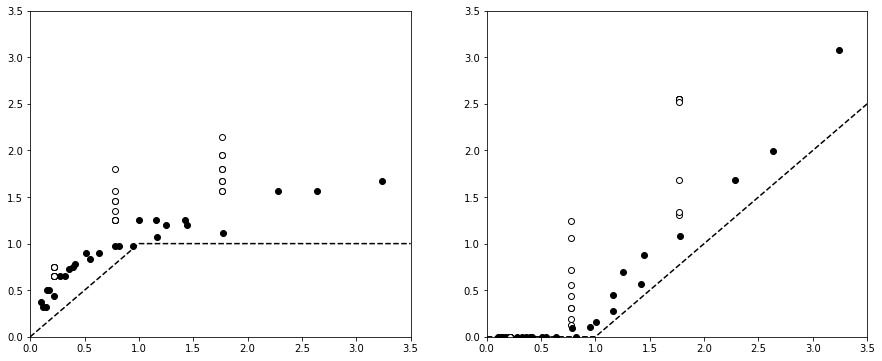

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
for ax, x, y in zip(axs, [(0, 1, 3.5), (0, 1, 3.5)], [(0, 1, 1), (0, 0, 2.5)]):
    ax.plot(x, y, 'k--')
    ax.set_xlim([0, 3.5])
    ax.set_ylim([0, 3.5])
sec = sections[1]
hour = 24

# Loop though z_h and rho_surf
for z_h in tqdm(param['z_h']):
    for rho_s in param['rho_surf']:

        # Calculate deformation radius
        R = calc_deformation_radius(rho_s, z_h, (sec['x'][0], sec['y']), angle=sec['a'])

        # Loop through wind speed
        for U, tau in zip(param['u_wind'], param['tau']):

            # Open results record
            runID = f'SalishSeaPond_S4d{U:02d}ms_halocline{z_h:2d}m_rhosurf{rho_s:4d}'
            with xr.open_dataset(os.path.join(path, runID, fn)) as data:
                
                for zh, r, color in zip([z_h, 10], [R, 1e4], ['k', 'w']):

                    # Loop through sections
                    scale = np.cos(np.arctan(2) - sec['a']) * tau * 3600 / (const['rho_0'] * zh * const['f'] * r)
                    xy = (sec['y'] - subdomain[2], slice(*[x - subdomain[0] for x in sec['x']]))
                    rho_t0 = calc_rho(data, depth2d, (0,slice(None))+xy, tmask, time=True)
                    rho_halo = np.median(rho_t0[abs(depth2d[:, 0] - zh).argmin(), :])

                    # Loop through hours
                    scale_T = (hour - 3) * scale
                    rho = calc_rho(data, 0, (hour,0)+xy, tmask, time=True)
                    z_u = depth2d[int(np.median(abs(rho_t0 - rho.max()).argmin(axis=0))), 0] / zh
                    x_u = np.sin(sec['a']) * (rho >= rho_halo).sum() * 440 / r
                    axs[0].plot(scale_T, z_u, 'ko', markerfacecolor=color)
                    axs[1].plot(scale_T, x_u, 'ko', markerfacecolor=color)

In [28]:
# Define paths and variables
paths = {
    'NEMO': '/results/SalishSea/hindcast.201812',
    'NEMO_cutoff': '/results2/SalishSea/hindcast.201812_annex',
    'date_cutoff': '2016 Nov 21',
}
tmask = mask.tmask
depthw = (depth2d[1:, 0] + depth2d[:-1, 0]) / 2

# Initialize storage lists
rho_t0 = [0, 0, 0, 0, 0, 0]
rho_halo = [0, 0, 0, 0, 0, 0]
R = [0, 0, 0, 0, 0, 0]
z_h = [0, 0, 0, 0, 0, 0]

In [29]:
# Upwelling event date windows
events = [parse(date) for date in [
    '2015 Mar 11 04:00', #1
    '2015 Mar 18 18:00', #2
    '2015 Mar 24 22:00', #3
    '2015 Mar 28 21:00', #4
    '2015 Apr 25 23:00', #5
    '2016 Apr 11 13:00', #6
    '2017 Apr 03 23:00', #7
    '2017 May 30 15:00', #8
    '2017 Sep 08 23:00', #9
    '2017 Sep 17 02:00', #10
    '2017 Oct 21 05:00', #11
    '2018 Mar 22 07:00', #12
    '2018 Apr 03 10:00', #13
    '2018 Apr 12 23:00', #14
    '2018 Sep 07 13:00', #15
    '2018 Sep 14 18:00', #16
    '2018 Oct 23 06:00', #17
]]

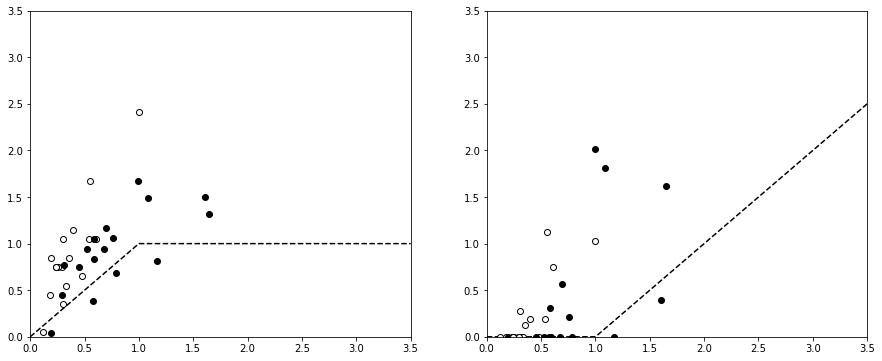

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
for ax, x, y in zip(axs, [(0, 1, 3.5), (0, 1, 3.5)], [(0, 1, 1), (0, 0, 2.5)]):
    ax.plot(x, y, 'k--')
    ax.set_xlim([0, 3.5])
    ax.set_ylim([0, 3.5])
sec = sections[1]
hour = 24

# Loop though events and hours
for event in tqdm(events):
    for hour in [0, hour]:

        date = event + timedelta(hours=hour)

        # Open hindcast record
        with xr.open_dataset(make_prefix(date, paths) + '_grid_T.nc') as data:

            # Loop through sections
            yx = (sec['y'], slice(*sec['x']))
            e1t = float(mask.e1t[0, sec['y'], sec['x'][0]])

            # Calculations at t=0
            if hour == 0:
                loc = (slice(None),) + yx
                rho_t0 = calc_rho(data.sel(time_counter=date, method='nearest'), depth2d, loc, tmask[0, ...])
                N2 = const['g'] / const['rho_0'] * np.diff(rho_t0, axis=0) / np.diff(depth2d, axis=0)
                modes = dynmodes(np.ma.median(N2[:, :20], axis=1).compressed()[:24], depthw[:24], 1)
                z_h = depthw[int(np.where(np.diff(np.signbit(modes[1][0, :])))[0])]
                rho_halo = np.median(rho_t0[abs(depth2d[:, 0] - z_h).argmin(axis=0), :])
                rho_surf = rho_t0[:int(z_h), :].mean()
                R = calc_deformation_radius(rho_surf, z_h, (sec['x'][0], sec['y']), angle=sec['a'])

            # Calculations at hours
            else:
                
                for zh, r, color in zip([z_h, 10], [R, 1e4], ['k', 'w']):

                    # Calculate upwelling metrics
                    rho = calc_rho(data.sel(time_counter=date, method='nearest'), 0, (0,) + yx, tmask[0, ...])
                    rho_max = rho[:max(1, int(r / 440))].max()
                    z_u = depth2d[int(np.median(abs(rho_t0 - rho_max).argmin(axis=0))), 0]
                    x_u = np.sin(sec['a']) * (rho >= rho_halo).sum() * 440

                    # Calculate scaling
                    loc = (slice(None), sec['yw'], slice(*sec['xw']))
                    u, v = [HRDPS.sel(time=slice(event, date))[k][loc].values for k in ['u_wind', 'v_wind']]
                    coeff = np.cos(np.pi * (22 / 180 + 1) - np.arctan2(v, u) - sec['a'])
                    tau = sum(1.225e-3 * (coeff * (u**2 + v**2)).mean(axis=1)) * 3600
                    scaling = tau / (const['rho_0'] * zh * const['f'] * r)
                    axs[0].plot(scaling, z_u / zh, 'ko', markerfacecolor=color)
                    axs[1].plot(scaling, x_u / r, 'ko', markerfacecolor=color)

